In [1]:
%%capture
!pip install osmnx pyrosm
!apt-get update -qq && apt-get install -y osmium-tool

In [11]:
!wget -nc https://download.geofabrik.de/russia/northwestern-fed-district-latest.osm.pbf

--2025-06-12 15:05:01--  https://download.geofabrik.de/russia/northwestern-fed-district-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 95.217.45.61, 95.217.63.98, 95.216.245.233, ...
Connecting to download.geofabrik.de (download.geofabrik.de)|95.217.45.61|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604077156 (576M) [application/octet-stream]
Saving to: ‘northwestern-fed-district-latest.osm.pbf’

northwestern-fed-di 100%[===================>] 576.09M  15.6MB/s    in 38s     

2025-06-12 15:05:39 (15.2 MB/s) - ‘northwestern-fed-district-latest.osm.pbf’ saved [604077156/604077156]



In [2]:
# Я решил использовать pyrosm вместо osmnx, потому что он ест меньше RAM
from pyrosm import OSM, get_data

import requests
from shapely.geometry import LineString
from shapely.ops import polygonize, unary_union
import json
import matplotlib.pyplot as plt
import pandas as pd

### **1. Данные по городу**

In [9]:
overpass_url = "https://overpass-api.de/api/interpreter"
query = """
[out:json][timeout:25];
relation["boundary"="administrative"]["admin_level"="4"]["name"="Санкт-Петербург"];
out geom;
"""
resp = requests.get(overpass_url, params={"data": query})
data = resp.json()

In [10]:
# Извлекаем relation и его членов
relation = data["elements"][0]
members = relation["members"]

# Собираем все линии «outer»
lines = []
for m in members:
    if m["role"] == "outer" and "geometry" in m:
        coords = [(pt["lon"], pt["lat"]) for pt in m["geometry"]]
        lines.append(LineString(coords))

# Делаем из линий полигоны и склеиваем
polygons = list(polygonize(lines))
boundary = unary_union(polygons)

# Сохраняем в GeoJSON (или сразу работаем в memory)
geojson_feature = {
    "type": "Feature",
    "properties": {},
    "geometry": json.loads(json.dumps(boundary.__geo_interface__))
}

with open("spb_boundary.geojson", "w", encoding="utf-8") as f:
    json.dump(geojson_feature, f, ensure_ascii=False, indent=2)

print("Граница сохранена в spb_boundary.geojson")

Граница сохранена в spb_boundary.geojson


In [13]:
!osmium extract \
    --overwrite \
    --output-format pbf \
    --polygon spb_boundary.geojson \
    northwestern-fed-district-latest.osm.pbf \
    -o spb-latest.osm.pbf

[======================================================================] 100% 


Поскольку карта Москвы в open source картах pbf устаревшая, я вручную вырезал новые административные границы (вот с этим хвостом Новой Москвы на Юго-Западе) на карте ЦФО России

### **2. Категории зданий**

In [14]:
# fp = get_data("moscow-latest.osm.pbf")
fp = "spb-latest.osm.pbf"

osm = OSM(fp)
buildings = osm.get_buildings()

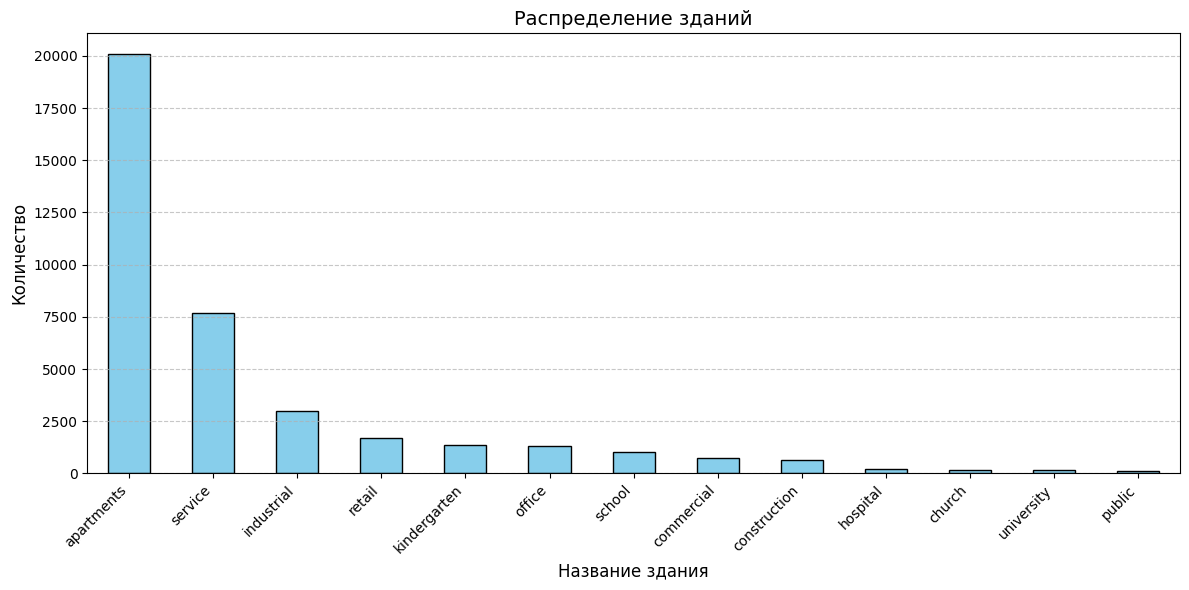

In [44]:
# Считаем частоту категорий и фильтруем высокочастотные
counts = buildings["building"].value_counts()
counts = counts[counts >= 100].sort_values(ascending=False)
counts = counts.drop(["yes", "guardhouse", "kiosk", "shed", "terrace",
                      "hangar", "house", "garages", "detached", "greenhouse", "ruins",
                      "garage", "bungalow", "roof", "warehouse", "dormitory",
                      "store", "pavilion", "semidetached_house", "shelter",
                      "parking", "hotel", "storage_tank", "policlinic", "residential"])

# Создаем график
plt.figure(figsize=(12, 6))
counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Настройки оформления
plt.title('Распределение зданий', fontsize=14)
plt.xlabel('Название здания', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Поворот подписей
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Я отфильтровал категории и оставил что-то более-менее частовстречающееся. При желании можно еще сильнее снизить размерность и оставить прям совсем частые (apartments, industrial, commercial etc.)

In [16]:
# Посмотрим все адм.границы в датасете ЦФО
names_list = osm.get_boundaries()["name"].tolist()  # Преобразует столбец в список Python
print(names_list)

['Ленинградская область', 'Санкт-Петербург', 'Колпино', 'Колпинский район', 'Понтонный', 'Сапёрный', 'Металлострой', 'Усть-Ижора', 'Петро-Славянка', 'Пушкинский район', 'Московский район', 'округ Московская застава', 'Шушары', 'Александровская', 'Тярлево', 'Пушкин', 'Павловск', 'Красное Село', 'округ Горелово', 'Красносельский район', 'Южно-Приморский округ', 'округ Сосновая поляна', 'округ Урицк', 'округ Константиновское', 'округ Юго-Запад', 'Петродворцовый район', 'Стрельна', 'Петергоф', 'Ломоносов', 'Невский район', 'округ Невская застава', 'Народный округ', 'округ № 54', 'Обуховский округ', 'округ Рыбацкое', 'Ивановский округ', 'Фрунзенский район', 'округ Правобережный', 'Невский округ', 'округ Оккервиль', 'Ломоносовский район', 'Полянское сельское поселение', 'Адмиралтейский район', 'Василеостровский район', 'Выборгский район', 'Калининский район', 'Кировский район', 'Красногвардейский район', 'Центральный район', 'Петроградский район', 'Кронштадтский район', 'Курортный район', 'П

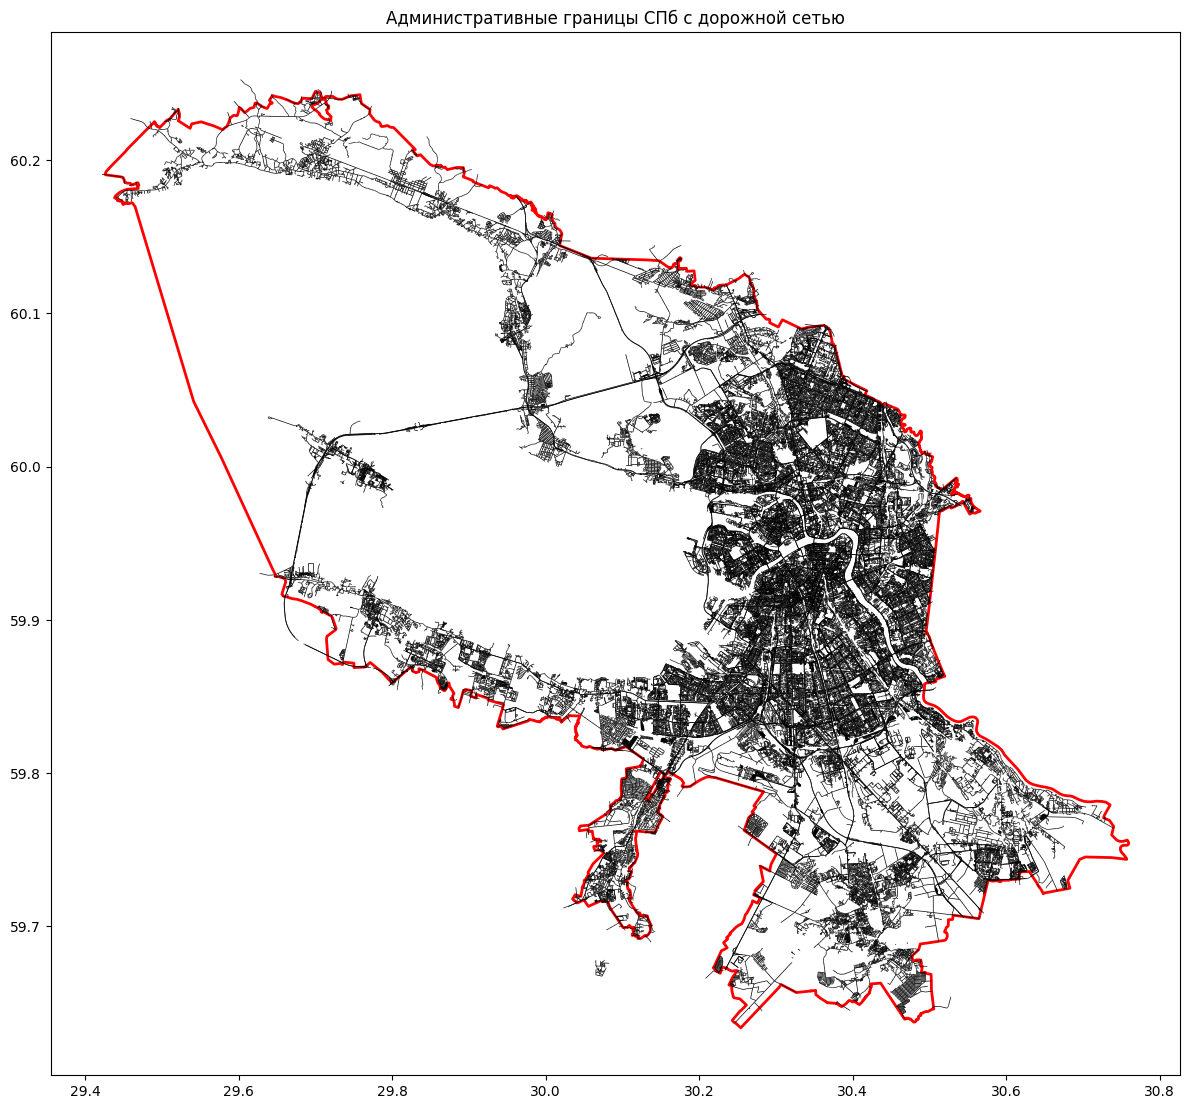

In [23]:
# Получаем административные границы
boundaries = osm.get_boundaries()
spb_boundary = boundaries[boundaries["name"] == "Санкт-Петербург"]

# Создаем карту
fig, ax = plt.subplots(figsize=(12, 12))

# Фон
# water.plot(ax=ax, color="lightblue", alpha=0.5)

# Границы города
spb_boundary.plot(ax=ax, color="none", edgecolor="red", linewidth=2)

# Дороги
roads.plot(ax=ax, color="black", linewidth=0.5)

ax.set_title("Административные границы СПб с дорожной сетью")
plt.tight_layout()
plt.show()

<Axes: >

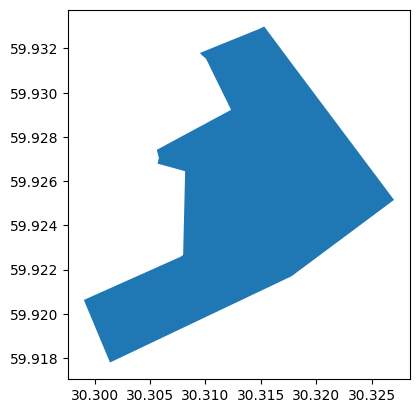

In [57]:
# Получаем все административные границы
boundaries = osm.get_boundaries()

# Фильтруем
bounding_box = boundaries[
    boundaries['name'].str.contains("Сенной округ", case=False, na=False)
]

# Визуализируем
bounding_box.plot()

In [58]:
# возьмем границы
bbox_geom = bounding_box['geometry'].values[0]

# Инициализируем OSM по ним
osm_2 = OSM(fp, bounding_box=bbox_geom)

In [59]:
# Достанем здания
hood = osm_2.get_buildings()

# Отфильтруем по высокочастотным категориям
hood = hood[hood["building"].isin(counts.reset_index()["building"])]

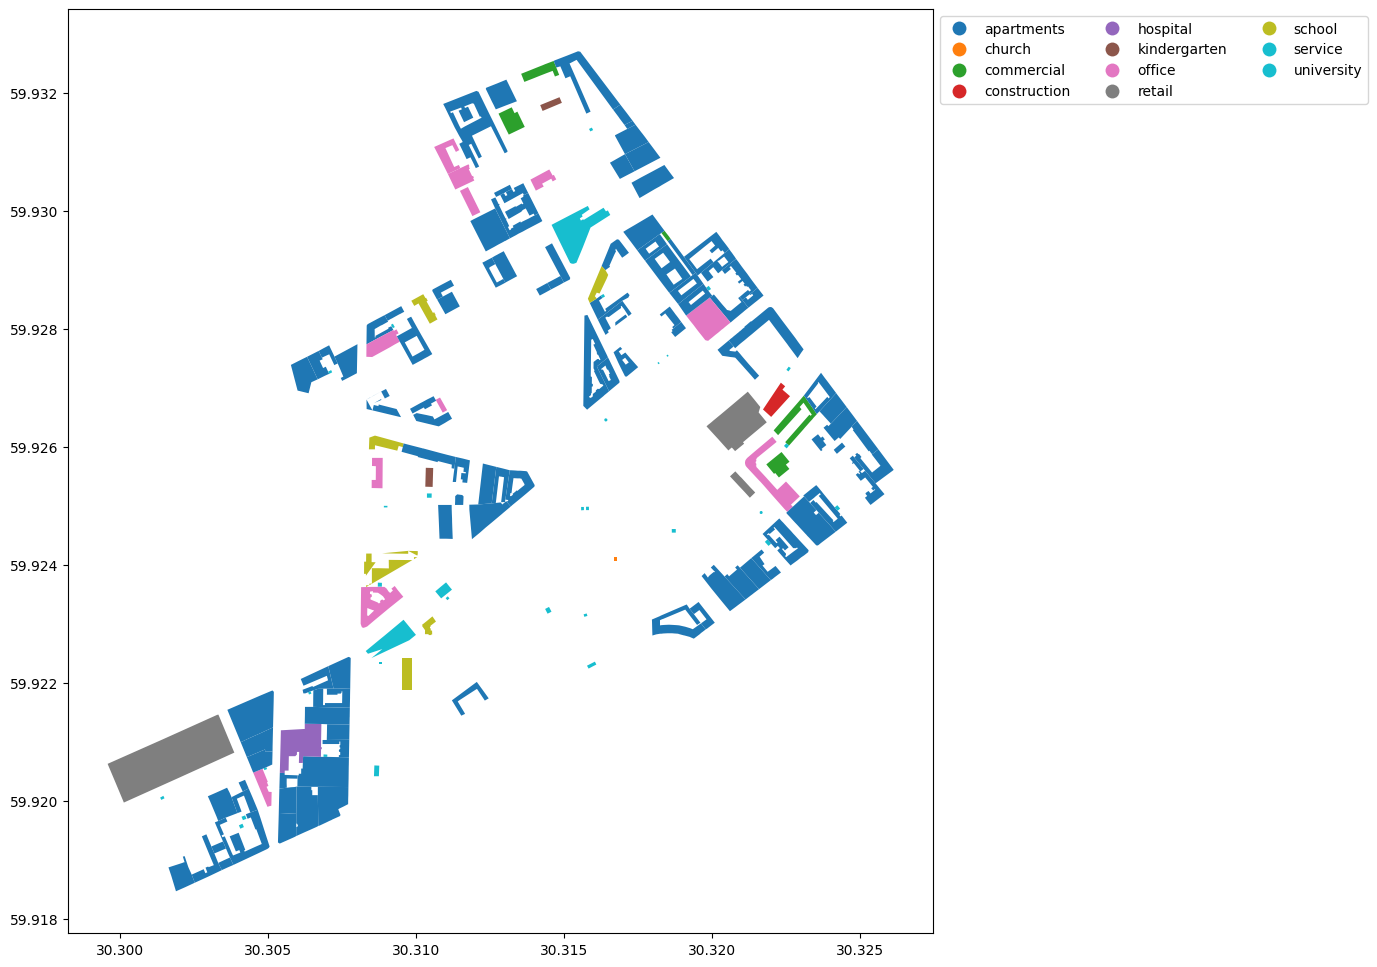

In [60]:
# Визуализируем
ax = hood.plot(column="building", figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=3, bbox_to_anchor=(1, 1)))

## **3. Точки интереса (POI)**

In [61]:
# Укрупненная категория: все тэги в ней
CATEGORY_MAPPING = {
    "food_out": [
        "restaurant", "cafe", "fast_food", "bar", "pub", "ice_cream", "food_court",
        "bakery"
    ],
    "food_buy": [
        "supermarket", "butcher", "convenience", "greengrocer", "deli",
        "confectionery", "seafood", "cheese", "wine", "beverages", "alcohol"
    ],
    "education": [
        "school", "university", "college", "kindergarten", "childcare", "nursery",
        "library", "research_institute", "language_school", "music_school",
        "driving_school", "tutoring", "educational_institution"
    ],
    "transport": [
        "bus_station", "taxi", "bus_stop", "train_station", "subway_entrance"
    ],
    "health": [
        "hospital", "clinic", "pharmacy", "doctors", "dentist", "veterinary",
        "medical_center"
    ],
    "shopping": [
        "department_store", "mall", "clothes", "electronics", "boutique", "shoes", "fashion",
        "jewelry", "watches", "accessories", "variety_store", "second_hand", "thrift_store",
        "chemist", "cosmetics", "beauty", "medical_supply", "perfumery", "agrarian", "appliance",
        "electrical","florist", "hardware", "houseware", "furniture", "kitchen", "bed",
        "computer", "mobile_phone", "outdoor", "sports", "fishing", "hunting", "bicycle",
        "books", "stationery", "gift", "toy", "pet", "music", "anime",
        "laundry", "dry_cleaning", "e-cigarette", "pawnbroker",
        "wholesale", "telecommunication"
    ],
    "sports": [
        "fitness_center", "gym", "sports_center", "swimming_pool", "yoga", "dance",
        "stadium", "pitch", "golf_course", "bowling_alley", "ski_rental", "ice_rink",
        "marina", "water_park", "sauna", "horse_riding", "sports_hall", "tennis", "volleyball",
        "basketball", "skateboard", "surfing"
    ],
    "services": [
        "bank", "atm", "post_office",
        "coworking", "notary", "lawyer", "accountant", "surveyor", "architect",
        "computer_repair", "electrician", "locksmith", "tailor", "hvac","pet_grooming",
        "nail_salon", "massage", "hairdresser","barber"
    ],
    "religion": [
        "place_of_worship", "church", "mosque", "temple", "synagogue", "shrine", "cathedral",
        "chapel", "monastery"
    ],
    "leisure": [
        "community_center", "cultural_center","theatre", "cinema", "opera", "planetarium",
        "social_center", "museum", "gallery", "arts_centre", "theme_park", "amusement_arcade",
        "beach_resort"
    ],
    "nature": [
        "park", "garden", "forest", "nature_reserve", "beach"
    ]
}

In [62]:
# Все тэги в ней: укрупненная категория
REVERSE_MAPPING = {}
for category, tags in CATEGORY_MAPPING.items():
    for tag in tags:
        REVERSE_MAPPING[tag] = category  # Теперь каждый тег ведёт прямо к категории

Я субъективно взял, пожалуй, самые важные тэги и придумал ряд укрупненных категорий, чтобы не перегружать алгоритм.

Как вы видите, я еще сделал что-то вроде invert крупная категория:тэг -> тэг:крупная категория, поскольку так быстрее все считается )

In [63]:
# Достаёт значение тега из строки вида 'amenity=restaurant'
def extract_tag_value(osm_tag):
    if pd.isna(osm_tag):
        return None
    if '=' in osm_tag:
        return osm_tag.split('=')[1]  # берём часть после '='
    return osm_tag

# Тэг в укрупненную категорию
def map_poi_to_category(osm_tag):
    tag_value = extract_tag_value(osm_tag)
    if not tag_value:
        return "other"
    return REVERSE_MAPPING.get(tag_value, "other")  # O(1) поиск!

In [64]:
# Там 3 тэга: amenity, shop, tourism
custom_filter = {'amenity': True, "shop": True}
pois = osm_2.get_pois(custom_filter=custom_filter) # GeoPandas DataFrame

# Собираем информацию по тэгам
pois["poi_type"] = pois["amenity"]
pois["poi_type"] = pois["poi_type"].fillna(pois["shop"])

In [65]:
# Добавляем колонку 'category' на основе тегов
pois['category'] = pois['poi_type'].apply(map_poi_to_category)
pois = pois[pois["category"] != "other"]

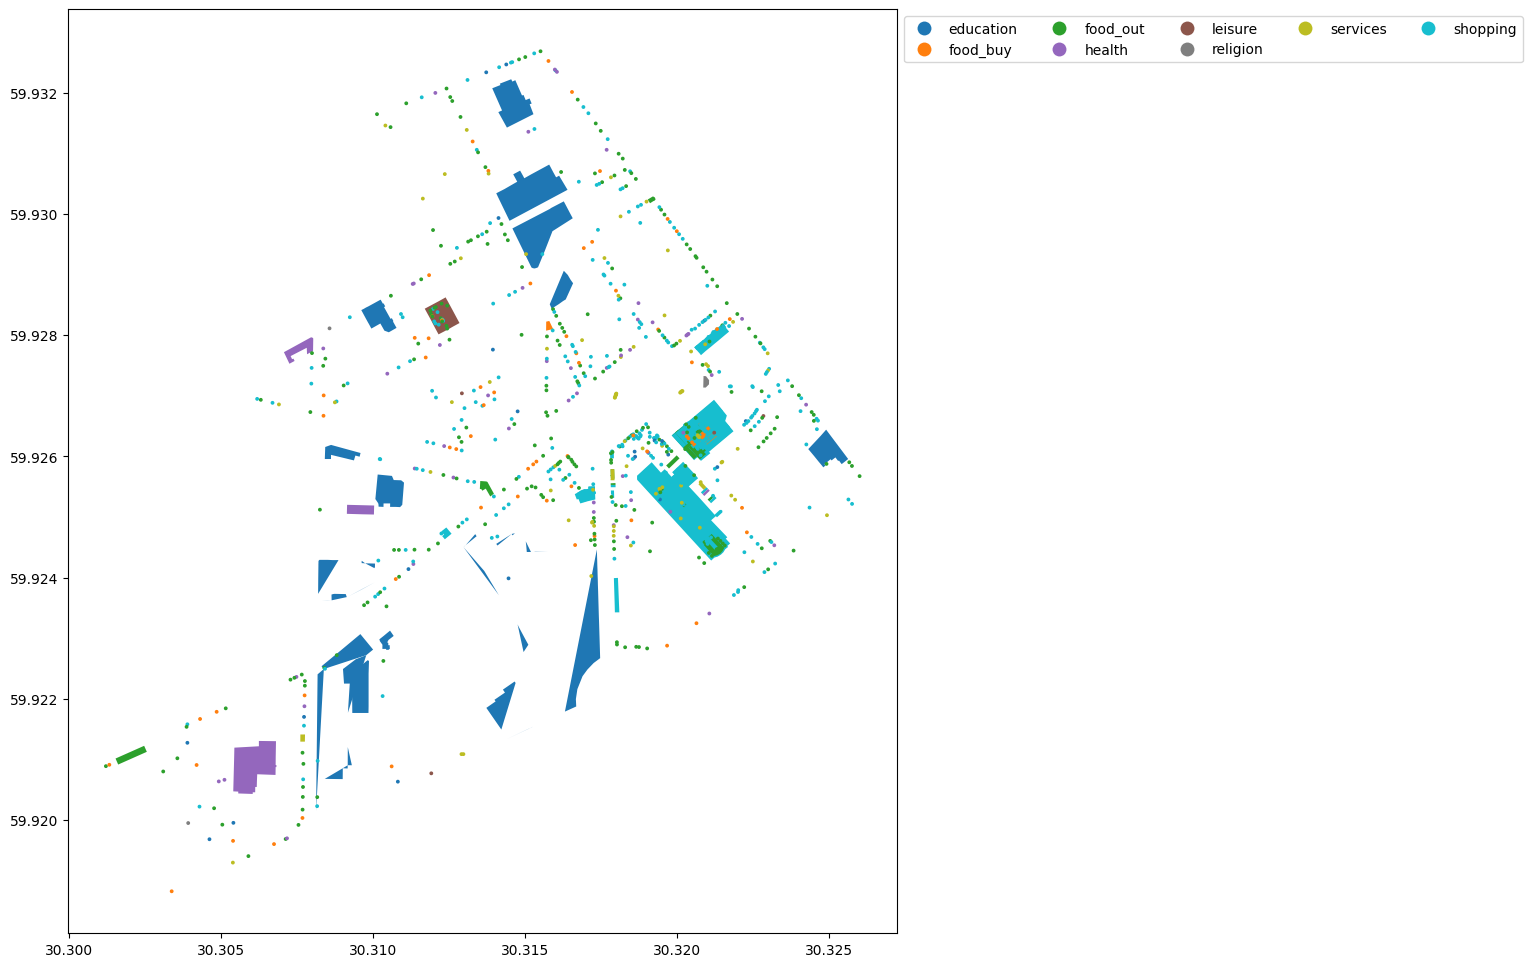

In [66]:
# Визуализируем
ax = pois.plot(column='category', markersize=3, figsize=(12,12), legend=True, legend_kwds=dict(loc='upper left', ncol=5, bbox_to_anchor=(1, 1)))